# Dropping Columns

This notebook identifies and removes redundant features through correlation analysis and PCA.

In [49]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

df = pd.read_csv('../datasets/anomaly_removed_column_organised.csv')

numerical_columns =    ['score', 'user score', 'critics', 'users',
                       'price', 'dlc_count', 'achievements',
                       'average_playtime_forever', 'average_playtime_2weeks',
                       'median_playtime_forever', 'median_playtime_2weeks',
                       'total_steam_reviews', 'percent_positive_steam', 'Estimated_Owners_Numeric']

print(df[numerical_columns].dtypes)
print(df.shape[0])

score                         int64
user score                   object
critics                       int64
users                         int64
price                       float64
dlc_count                     int64
achievements                  int64
average_playtime_forever      int64
average_playtime_2weeks       int64
median_playtime_forever       int64
median_playtime_2weeks        int64
total_steam_reviews           int64
percent_positive_steam      float64
Estimated_Owners_Numeric    float64
dtype: object
1812


### Data Cleaning

`user score` is cast to numeric, any non-numeric values (e.g. `'tbd'`) are coerced to NaN, then rows with any missing values are dropped. The row counts before and after confirm how many are lost (33).

In [50]:
df['user score'] = pd.to_numeric(df['user score'], errors='coerce')
df.replace('tbd', np.nan, inplace=True)
print(df.shape[0])
df = df.dropna()
print(df.shape[0])
# print(df[numerical_columns].dtypes)

1812
1779


## Correlation Analysis

A full correlation matrix across all numerical features. The heatmap gives a visual overview of which features are strongly related.

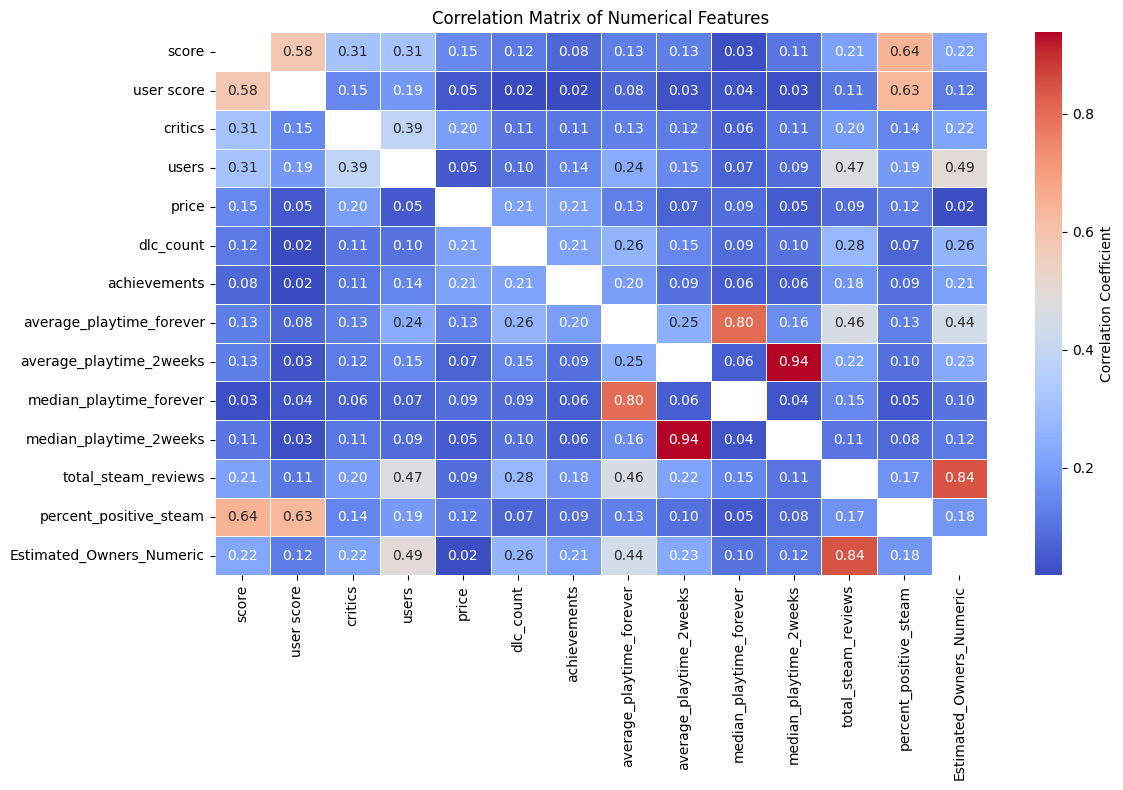

In [51]:
corr_matrix = df[numerical_columns].corr()

# num_columns_small = ['score', 'user score', 'critics', 'users']
# corr_matrix_small = df[num_columns_small].corr()
# print(corr_matrix)

mask = np.eye(len(corr_matrix), dtype=bool)

plt.figure(figsize=(12, 8))
sns.heatmap(corr_matrix, mask=mask, cmap='coolwarm', fmt='.2f', linewidths=0.5, annot_kws={'size': 10}, cbar_kws={'label': 'Correlation Coefficient'}, annot=True)
plt.title('Correlation Matrix of Numerical Features')
plt.savefig('../graphs/Initial Correlation Matrix.png', dpi=300, bbox_inches='tight')
plt.tight_layout()
plt.show()

### Dropping Highly Correlated Features

Features with a pairwise correlation above 0.75 are dropped. he dropped column names are listed below for reference.

In [52]:
threshold = 0.75
corr_matrix_upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))

high_corr = [column for column in corr_matrix_upper.columns if any(corr_matrix_upper[column] >= threshold)]

df2 = df.drop(columns=high_corr)

print(f"Columns dropped due to high correlation: {high_corr}")

Columns dropped due to high correlation: ['median_playtime_forever', 'median_playtime_2weeks', 'Estimated_Owners_Numeric']


## PCA

PCA is used here to check whether the remaining features can be compressed further without losing too much information. The plot shows how many components are needed to explain 95% of the variance. If that number is small relative to the total features, it suggests the data has a lot of redundancy worth exploiting before clustering.

Number of components to keep 95% variance: 10


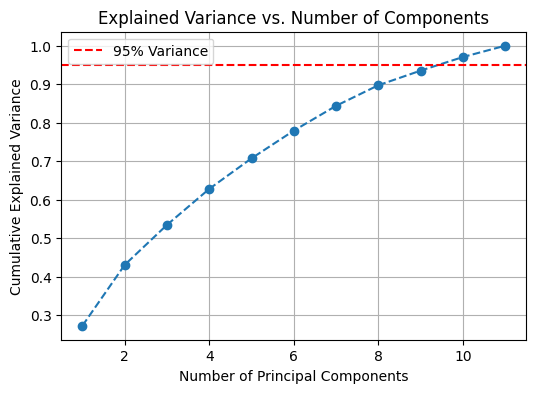

In [53]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

numerical_columns_drop =    ['score', 'user score', 'critics', 'users',
                       'price', 'dlc_count', 'achievements',
                       'average_playtime_forever', 'average_playtime_2weeks',
                       'total_steam_reviews', 'percent_positive_steam']

X =  df2[numerical_columns_drop]

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

pca = PCA()
pca.fit(X_scaled)

explained_variance = np.cumsum(pca.explained_variance_ratio_)

n_components = np.argmax(explained_variance >= 0.95) + 1
print(f"Number of components to keep 95% variance: {n_components}")

plt.figure(figsize=(6, 4))
plt.plot(range(1, len(explained_variance) + 1), explained_variance, marker='o', linestyle='--')
plt.axhline(y=0.95, color='r', linestyle='--', label="95% Variance")
plt.xlabel("Number of Principal Components")
plt.ylabel("Cumulative Explained Variance")
plt.title("Explained Variance vs. Number of Components")
plt.savefig('../graphs/PCA Analysis.png', dpi=300, bbox_inches='tight')
plt.legend()
plt.grid()
plt.show()

### PCA Loadings and Feature Importance

The component loadings are inspected to see which original features contribute most across all principal components. Features with consistently low absolute loadings are the least informative — summing absolute loadings across all PCs gives a rough importance score per feature.

In [54]:
loadings = pd.DataFrame(pca.components_.T, 
                        columns=[f'PC{i+1}' for i in range(len(X.columns))],
                        index=X.columns)

print("PCA Component Loadings:")
#print(loadings)
print(pca.explained_variance_ratio_)
print(np.cumsum(pca.explained_variance_ratio_))
importance_scores = loadings.abs().sum(axis=1)

least_important_features = importance_scores.sort_values()
print("Least Important Features:")
print(least_important_features)

PCA Component Loadings:
[0.27309625 0.15789469 0.10383874 0.09343864 0.0793263  0.07191207
 0.06443638 0.05343347 0.03796037 0.03528937 0.02937372]
[0.27309625 0.43099093 0.53482967 0.62826831 0.70759461 0.77950668
 0.84394306 0.89737653 0.9353369  0.97062628 1.        ]
Least Important Features:
score                       2.210499
user score                  2.229517
achievements                2.362351
average_playtime_2weeks     2.362411
percent_positive_steam      2.380823
dlc_count                   2.557856
critics                     2.595206
users                       2.647603
price                       2.663629
average_playtime_forever    2.714846
total_steam_reviews         2.790131
dtype: float64


## Save

The reduced DataFrame is saved for use in subsequent notebooks.

In [55]:
df2.to_csv('../datasets/more_dropped_columns.csv', index=False)

In [56]:
# import matplotlib.pyplot as plt
# import numpy as np

# bins = np.arange(min(df2['user score']), max(df2['user score']) + 0.1, 0.1)

# plt.hist(df2['user score'], bins=bins, alpha=0.7, color='blue', edgecolor='black')

# plt.xlabel("User Score")
# plt.ylabel("Frequency")
# plt.title("Histogram of User Scores with 0.1 Interval Bins")

# plt.show()

## User Score Distribution

Skewness and kurtosis of the `user score` column — checking whether the distribution deviates meaningfully from normal before fitting distribution models.

In [57]:
from scipy.stats import skew, kurtosis

data = df2['user score']
skew_value = skew(data)
kurt_value = kurtosis(data)

print(f"Skewness: {skew_value:.2f}")
print(f"Kurtosis: {kurt_value:.2f}")

Skewness: -1.24
Kurtosis: 2.28


### Fitting Normal and Skewed Normal Distributions

Both a standard normal and a skewed normal are fitted to the `user score` data and overlaid on the histogram. The skewed normal has an additional shape parameter to capture any asymmetry in the distribution.

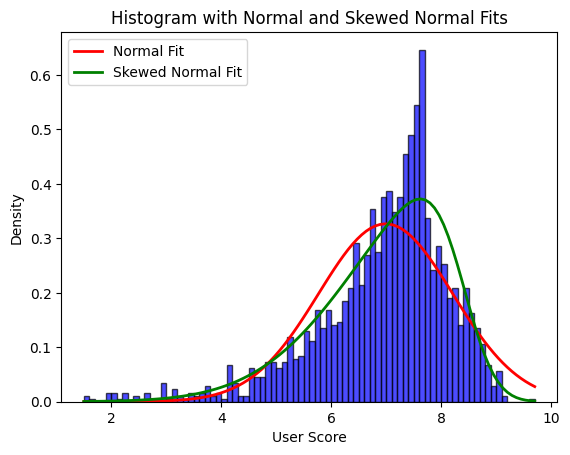

In [58]:
from scipy.stats import norm, skewnorm

data = df2['user score']

params_normal = norm.fit(data)
params_skewed = skewnorm.fit(data)

x_vals = np.linspace(min(data), max(data), 100)

y_vals_normal = norm.pdf(x_vals, *params_normal)
y_vals_skewed = skewnorm.pdf(x_vals, *params_skewed)

bins = np.arange(min(data), max(data) + 0.1, 0.1)  # Adjust bin width to 0.1
plt.hist(data, bins=bins, alpha=0.7, color='blue', edgecolor='black', density=True)

plt.plot(x_vals, y_vals_normal, color='red', label="Normal Fit", linewidth=2)
plt.plot(x_vals, y_vals_skewed, color='green', label="Skewed Normal Fit", linewidth=2)

plt.savefig('../graphs/User Score Histogram.png', dpi=300, bbox_inches='tight')
plt.xlabel("User Score")
plt.ylabel("Density")
plt.title("Histogram with Normal and Skewed Normal Fits")

plt.legend()

plt.show()

### Model Comparison via AIC

AIC (Akaike Information Criterion) penalises model complexity: lower AIC means a better fit relative to the number of parameters used. The skewed normal has one extra parameter (k=3 vs k=2), so it needs to fit meaningfully better to win on AIC.

In [59]:
log_likelihood_normal = np.sum(np.log(norm.pdf(data, *params_normal)))
log_likelihood_skewed = np.sum(np.log(skewnorm.pdf(data, *params_skewed)))

k_normal = 2  # Normal distribution has 2 parameters (mean, std)
k_skewed = 3  # Skewed normal distribution has 3 parameters (mean, std, skew)

AIC_normal = 2 * k_normal - 2 * log_likelihood_normal
AIC_skewed = 2 * k_skewed - 2 * log_likelihood_skewed

print(f"Normal Log-Likelihood: {log_likelihood_normal:.2f}")
print(f"Skewed Normal Log-Likelihood: {log_likelihood_skewed:.2f}")
print(f"Normal AIC: {AIC_normal:.2f}")
print(f"Skewed Normal AIC: {AIC_skewed:.2f}")

if AIC_normal < AIC_skewed:
    print("Normal distribution fits the data better (lower AIC).")
else:
    print("Skewed normal distribution fits the data better (lower AIC).")

Normal Log-Likelihood: -2879.95
Skewed Normal Log-Likelihood: -2709.00
Normal AIC: 5763.90
Skewed Normal AIC: 5423.99
Skewed normal distribution fits the data better (lower AIC).


## Critics vs User Ratings

Linear regression between critic score and user score (scaled to the same range). The correlation coefficient gives a sense of how aligned the two rating systems are.

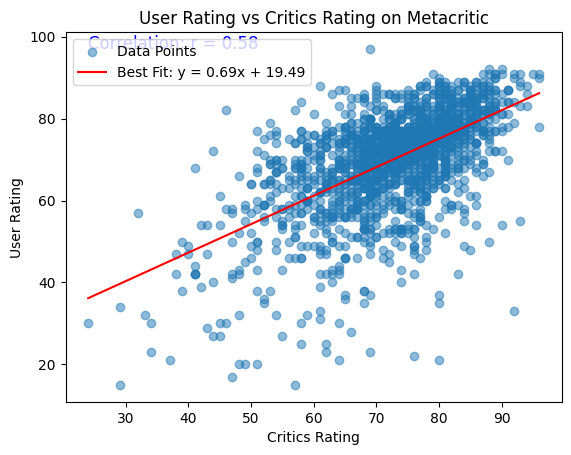

Equation of best fit: y = 0.69x + 19.49
Correlation coefficient (r): 0.58


In [60]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import linregress

# Extract X and Y values
x = df2['score']
y = df2['user score']*10

slope, intercept, r_value, p_value, std_err = linregress(x, y)

x_fit = np.linspace(min(x), max(x), 100)
y_fit = slope * x_fit + intercept

plt.scatter(x, y, alpha=0.5, label="Data Points")

plt.plot(x_fit, y_fit, color="red", label=f"Best Fit: y = {slope:.2f}x + {intercept:.2f}")

plt.text(min(x), max(y), f"Correlation: r = {r_value:.2f}", fontsize=12, color="blue")

plt.xlabel("Critics Rating")
plt.ylabel("User Rating")
plt.title("User Rating vs Critics Rating on Metacritic")


plt.legend()
plt.show()

print(f"Equation of best fit: y = {slope:.2f}x + {intercept:.2f}")
print(f"Correlation coefficient (r): {r_value:.2f}")

In [61]:
# x = df2['user score']*10
# y = df2['user score']*10 - df['score']

# # Calculate linear regression
# slope, intercept, r_value, p_value, std_err = linregress(x, y)

# # Generate fitted line
# x_fit = np.linspace(min(x), max(x), 100)
# y_fit = slope * x_fit + intercept
# y_mean = np.mean(y)

# # Scatter plot
# plt.scatter(x, y, alpha=0.2, label="Data Points")


# # Line of best fit
# plt.plot(x_fit, y_fit, color="red", label=f"Best Fit: y = {slope:.2f}x + {intercept:.2f}")
# # Correlation coefficient
# plt.text(min(x), max(y), f"Correlation: r = {r_value:.2f}", fontsize=12, color="blue")
# plt.axhline(y_mean, color="green", linestyle="dashed", linewidth=2, label=f"Mean Rating Difference = {y_mean:.2f}")

# # Labels and title
# plt.xlabel("User Rating")
# plt.ylabel("Rating Difference")
# plt.title("Difference between User & Critics Rating vs User Rating")
# plt.savefig("user_vs_critics.png", dpi=300, bbox_inches="tight")
# plt.legend()
# plt.show()

# # Print regression equation
# print(f"Equation of best fit: y = {slope:.2f}x + {intercept:.2f}")
# print(f"Correlation coefficient (r): {r_value:.2f}")

### User Score vs Score and Steam Positive Percentage

Two scatter plots side by side comparing how well Metacritic critic scores and Steam positive review percentages each correlate with Metacritic user scores. 
Useful for understanding whether the two platforms' audiences agree.

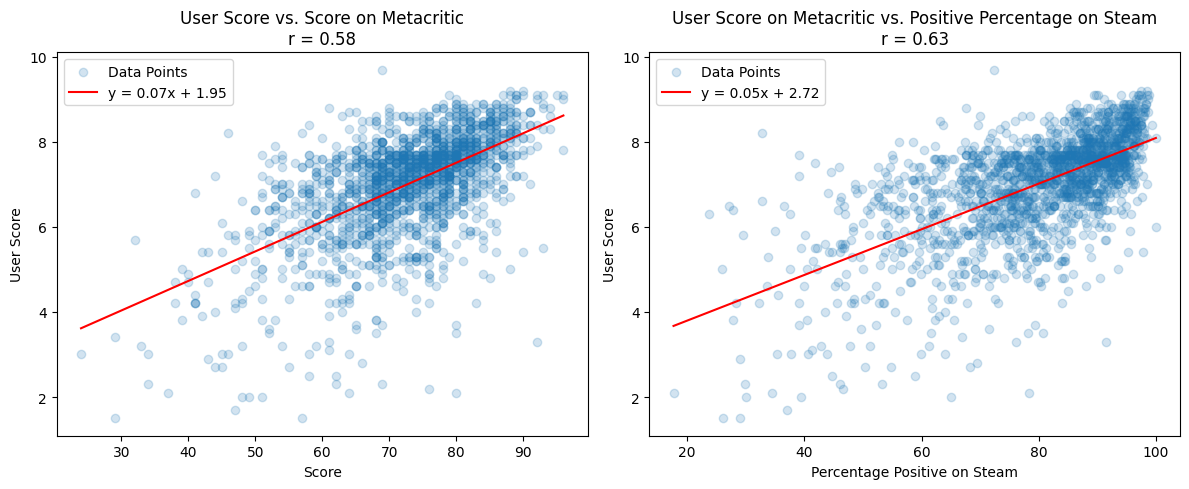

Equation 1: y = 0.07x + 1.95, r = 0.58
Equation 2: y = 0.05x + 2.72, r = 0.63


In [62]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import linregress

fig, axes = plt.subplots(1, 2, figsize=(12, 5))

x1 = df2['score']
y1 = df2['user score']
slope1, intercept1, r_value1, _, _ = linregress(x1, y1)
x_fit1 = np.linspace(min(x1), max(x1), 100)
y_fit1 = slope1 * x_fit1 + intercept1

axes[0].scatter(x1, y1, alpha=0.2, label="Data Points")
axes[0].plot(x_fit1, y_fit1, color="red", label=f"y = {slope1:.2f}x + {intercept1:.2f}")
axes[0].set_xlabel("Score")
axes[0].set_ylabel("User Score")
axes[0].set_title(f"User Score vs. Score on Metacritic\nr = {r_value1:.2f}")
axes[0].legend()

x2 = df2['percent_positive_steam']*100
y2 = df2['user score']
slope2, intercept2, r_value2, _, _ = linregress(x2, y2)
x_fit2 = np.linspace(min(x2), max(x2), 100)
y_fit2 = slope2 * x_fit2 + intercept2

axes[1].scatter(x2, y2, alpha=0.2, label="Data Points")
axes[1].plot(x_fit2, y_fit2, color="red", label=f"y = {slope2:.2f}x + {intercept2:.2f}")
axes[1].set_xlabel("Percentage Positive on Steam")
axes[1].set_ylabel("User Score")
axes[1].set_title(f"User Score on Metacritic vs. Positive Percentage on Steam\nr = {r_value2:.2f}")
axes[1].legend()
plt.savefig("../graphs/user_score_scatters.png", dpi=300, bbox_inches="tight")
plt.tight_layout()
plt.show()

print(f"Equation 1: y = {slope1:.2f}x + {intercept1:.2f}, r = {r_value1:.2f}")
print(f"Equation 2: y = {slope2:.2f}x + {intercept2:.2f}, r = {r_value2:.2f}")
